# 0. Imports

## 0.1. Libraries

In [1]:
import os
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import folium

import inflection

## 0.2. Loading data

In [2]:
# Function for download data from source
def download_data(download_url, local_folder_path, file_name):
    os.makedirs(local_folder_path, exist_ok=True)
    urllib.request.urlretrieve(download_url, os.path.join(local_folder_path, file_name))

In [3]:
# Parameters for download data
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv'
LOCAL_FOLDER = os.getcwd()
NEW_LOCAL_FOLDER = 'datasets'
LOCAL_FOLDER_PATH = os.path.join(LOCAL_FOLDER, NEW_LOCAL_FOLDER)
FILE_NAME = 'housing.csv'

In [4]:
download_data(download_url = DOWNLOAD_ROOT, local_folder_path = LOCAL_FOLDER_PATH, file_name = FILE_NAME)

In [5]:
df_raw = pd.read_csv(os.path.join(NEW_LOCAL_FOLDER, FILE_NAME))

# 1. EDA

## 1.1. Data description

### 1.1.1. Buisiness Problem

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. It is required to implement a Machine Learning regression model to predict a house value.
It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people)

https://www.kaggle.com/datasets/camnugent/california-housing-prices

### 1.1.2. Data types and feature description

In [6]:
df_raw.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df_raw.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
df_raw.duplicated().sum()

0

- **Rows**: 20640
- **Features**: 10
- 207 missing values in total_bedrooms

1. **longitude**: A measure of how far west a house is; a higher value is farther west
2. **latitude**: A measure of how far north a house is; a higher value is farther north
3. **housingMedianAge**: Median age of a house within a block; a lower number is a newer building
4. **totalRooms**: Total number of rooms within a block
5. **totalBedrooms**: Total number of bedrooms within a block
6. **population**: Total number of people residing within a block
7. **households**: Total number of households, a group of people residing within a home unit, for a block
8. **medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. **medianHouseValue**: Median house value for households within a block (measured in US Dollars)
10. **oceanProximity**: Location of the house w.r.t ocean/sea

### 1.1.3. Data profile

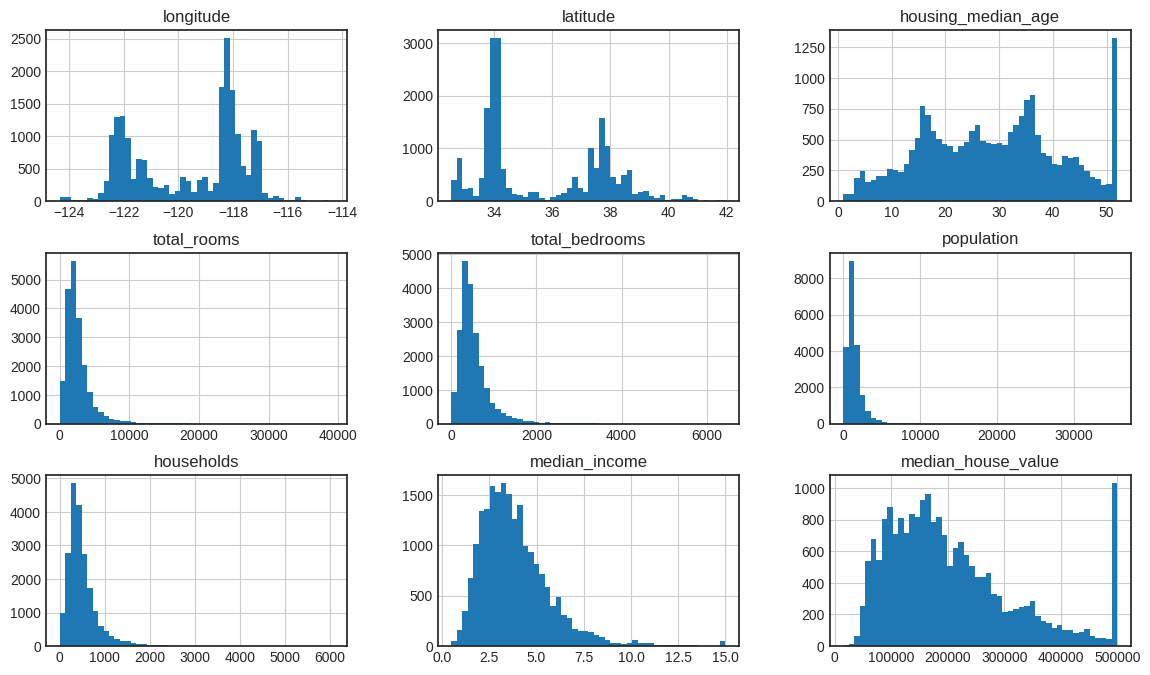

In [10]:
df_raw.hist(bins=50, figsize=(14,8));

**OBS.**
- Features need rescaling
- median_income is given as tens of thousand US dollars

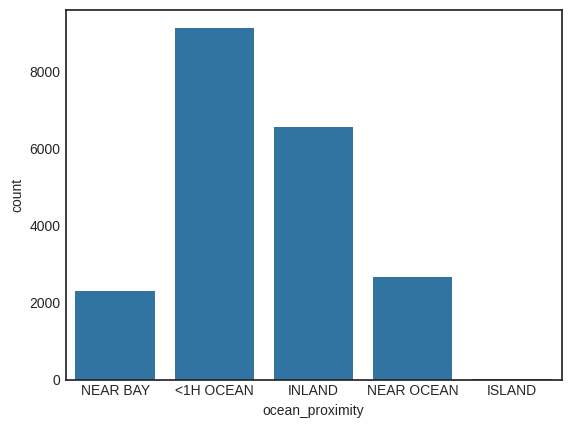

In [11]:
sns.countplot(data=df_raw, x='ocean_proximity');
#sns.barplot(data=df_raw, x='ocean_proximity', estimator='sum');

In [12]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


**OBS:**
- According to the data source, a block is around 600 to 3000 people, which means that the max value of 35k is far beyond. Outlier?

In [13]:
df_raw.query('total_rooms > 30000')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2288,-117.20,33.58,2.0,30450.0,5033.0,9419.0,3197.0,4.5936,174300.0,<1H OCEAN
5215,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND
8080,-118.78,34.16,9.0,30405.0,4093.0,12873.0,3931.0,8.0137,399200.0,NEAR OCEAN
9795,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
11617,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN
12328,-117.12,33.52,4.0,30401.0,4957.0,13251.0,4339.0,4.5841,212300.0,<1H OCEAN
18514,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN


- Blocks with low median age have huge quantity of rooms but low population
- This could imply low occupancy --> maybe population would not be a good feature

<Axes: xlabel='population'>

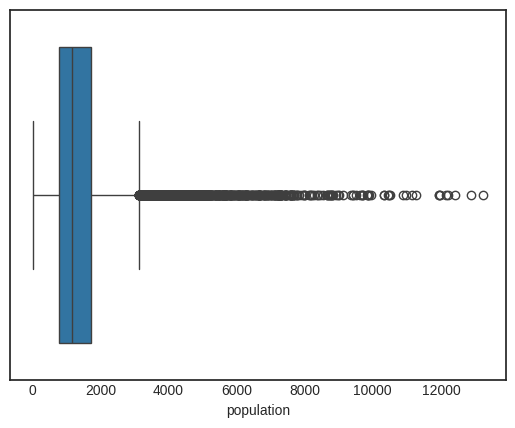

In [14]:
sns.boxplot(data=df_raw.query('population <= 15000'), x='population')

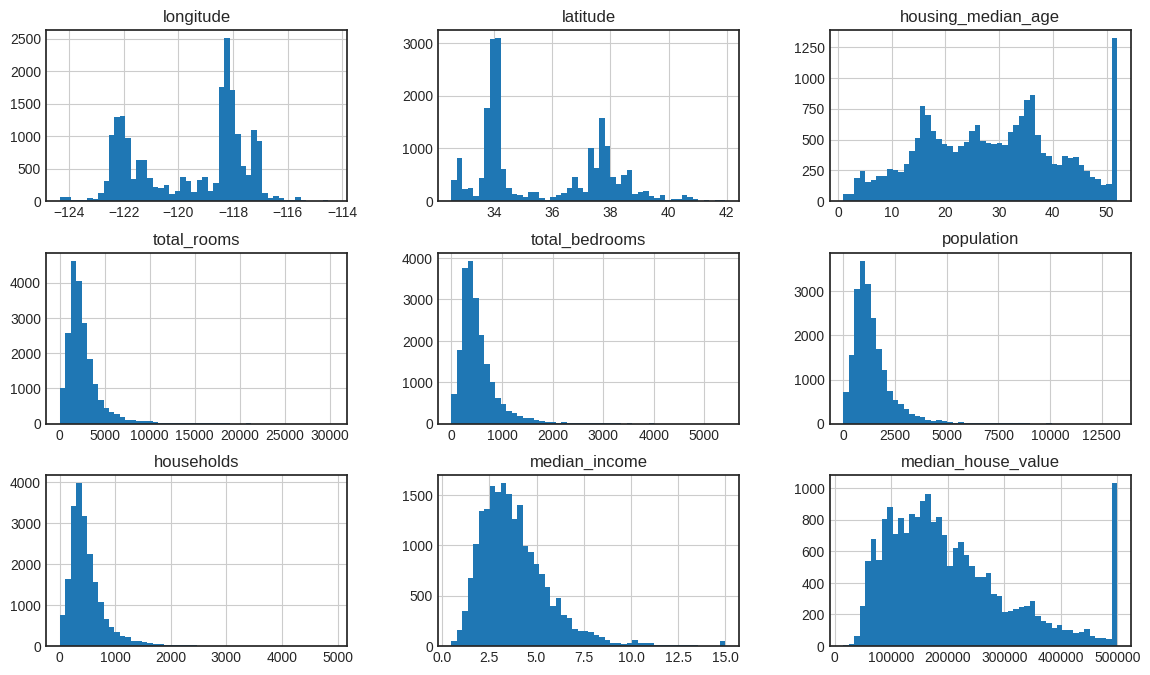

In [15]:
df_raw.query('population <= 15000').hist(bins=50, figsize=(14,8));

In [16]:
df_raw.query('population <= 15000').describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20634.0,-119.569868,2.003551,-124.3500,-121.8000,-118.4900,-118.0100,-114.3100
latitude,20634.0,35.632027,2.136011,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20634.0,28.645536,12.582217,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20634.0,2627.090094,2120.050650,2.0000,1447.0000,2126.0000,3145.7500,30450.0000
total_bedrooms,20427.0,536.441719,412.902789,1.0000,296.0000,435.0000,646.5000,5419.0000
population,20634.0,1419.725744,1072.588565,3.0000,787.0000,1166.0000,1724.0000,13251.0000
households,20634.0,498.205825,374.153665,1.0000,280.0000,409.0000,604.0000,4930.0000
median_income,20634.0,3.870344,1.899707,0.4999,2.5628,3.5347,4.7426,15.0001
median_house_value,20634.0,206849.726713,115399.560382,14999.0000,119600.0000,179700.0000,264700.0000,500001.0000


In [17]:
#df_raw.query('population > 6000')
aux = df_raw.query('population > 15000')[['latitude', 'longitude', 'population']]
#aux = df_raw.query('total_rooms > 20000')[['latitude', 'longitude', 'total_rooms']]

In [18]:
for row in aux.itertuples(index=False):
    print(row)

Pandas(latitude=38.43, longitude=-121.44, population=16305.0)
Pandas(latitude=34.04, longitude=-117.87, population=15037.0)
Pandas(latitude=36.64, longitude=-121.79, population=28566.0)
Pandas(latitude=33.89, longitude=-117.74, population=16122.0)
Pandas(latitude=33.35, longitude=-117.42, population=35682.0)
Pandas(latitude=34.03, longitude=-117.78, population=15507.0)


In [19]:
lat, long = 36.7014631, -118.755997
m = folium.Map(location=[lat, long],
               zoom_start=7)
for row in aux.itertuples(index=False):
    coord = [row[0], row[1]]
    folium.Marker(coord, popup=row[2]).add_to(m)
m

**OBS:**
- From the map, it is possible to see that the places with population greater than 15k are located in low density areas
- Information about such locations wil be removed

## 1.2. Data preparation

### 1.2.1. Split data into train and test

In [119]:
df_train, df_test = train_test_split(df_raw.query('population < 15000'), test_size=0.2, random_state=42)

X_train = df_train.drop(columns='median_house_value')
y_train = df_train[['median_house_value']].copy()

X_test = df_test.drop(columns='median_house_value')
y_test = df_test[['median_house_value']].copy()

Let's say we were informed that median income is a very important feature and the stratification in the values should be preserved.

The following histogram is presentend to verify if the proportions are similar between train and test samples.

Text(0.5, 1.0, 'Test')

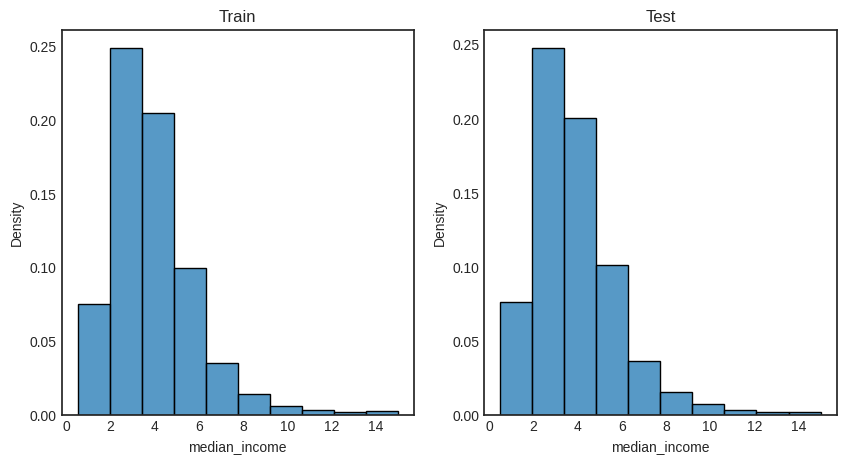

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(data=X_train['median_income'], bins=10, stat='density', ax=ax[0])
sns.histplot(data=X_test['median_income'], bins=10, stat='density', ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')

### 1.2.2. Handling missing values

In [121]:
df_train[df_train.isna().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19782,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,263800.0,NEAR OCEAN
1343,-120.32,37.29,38.0,576.0,NaN,478.0,112.0,2.3382,59600.0,INLAND
12188,-121.02,37.48,26.0,467.0,NaN,244.0,83.0,4.1346,187500.0,INLAND
182,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,118100.0,<1H OCEAN
16273,-122.08,37.37,29.0,1229.0,NaN,707.0,194.0,7.1108,465000.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
7619,-118.09,33.89,42.0,991.0,NaN,717.0,219.0,4.0926,164400.0,<1H OCEAN
13086,-118.40,34.17,24.0,6347.0,NaN,2945.0,1492.0,3.3545,221500.0,<1H OCEAN
4835,-120.98,37.60,36.0,1437.0,NaN,1073.0,320.0,2.1779,58400.0,INLAND
504,-118.08,33.92,38.0,1335.0,NaN,1011.0,269.0,3.6908,157500.0,<1H OCEAN


In [122]:
# Using KNN imputer
imputer_na = KNNImputer(n_neighbors=5)
X = imputer_na.fit_transform(X_train[['total_bedrooms']])
X_train['total_bedrooms'] = X

## Using median for replacing missing values
#imputer_na = SimpleImputer(strategy='median')
#X = imputer_na.fit_transform(X_train[['total_bedrooms']])
#X_train['total_bedrooms'] = X

In [123]:
X_train.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

### 1.2.3. Creating new features

**Median Rooms per household (Median rooms per house)**

In [124]:
X_train['rooms_per_house'] = X_train['total_rooms'] / X_train['households']

**Median Bedrooms per household (Median bedrooms per house)**

In [125]:
X_train['bedrooms_per_house'] = X_train['total_bedrooms'] / X_train['households']

**Median population per household (median number of people per house)**

In [126]:
X_train['population_per_house'] = X_train['population'] / X_train['households']

**Bedroom ratio**

In [127]:
X_train['bedroom_per_room'] = X_train['total_bedrooms'] / X_train['total_rooms']

In [128]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,16507.0,-119.570251,2.005299,-124.350000,-121.800000,-118.490000,-118.010000,-114.470000
latitude,16507.0,35.632970,2.135990,32.540000,33.930000,34.250000,37.710000,41.950000
housing_median_age,16507.0,28.580723,12.614764,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,16507.0,2633.968014,2130.300423,2.000000,1452.000000,2134.000000,3149.500000,30450.000000
total_bedrooms,16507.0,538.129589,412.972466,2.000000,298.000000,441.000000,643.000000,5419.000000
population,16507.0,1424.448537,1078.314074,3.000000,789.500000,1167.000000,1727.000000,13251.000000
households,16507.0,499.537590,375.595027,2.000000,281.000000,411.000000,604.000000,4930.000000
median_income,16507.0,3.866913,1.897336,0.499900,2.563100,3.531300,4.737800,15.000100
rooms_per_house,16507.0,5.436650,2.593322,1.000000,4.441016,5.233100,6.053356,141.909091
bedrooms_per_house,16507.0,1.107112,0.582173,0.149939,1.006400,1.049460,1.100499,34.066667


**OBS**: Max values in the new features are outliers? I need further informations, but they are not available in this project

### 1.2.4. Rescaling data

<Axes: >

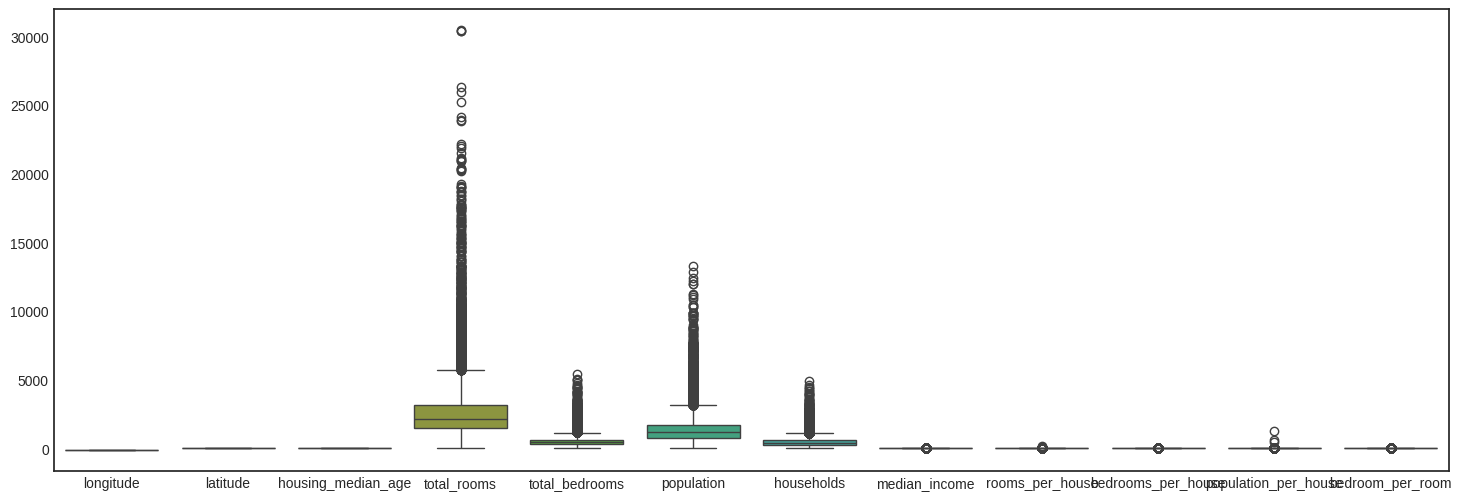

In [129]:
aux = X_train.drop(columns='ocean_proximity')

plt.figure(figsize=(18,6))
sns.boxplot(data=X_train)

In [130]:
# Standardization
std_scaler = StandardScaler().set_output(transform='pandas')
X_train_num = std_scaler.fit_transform(X=X_train.drop(columns='ocean_proximity'))

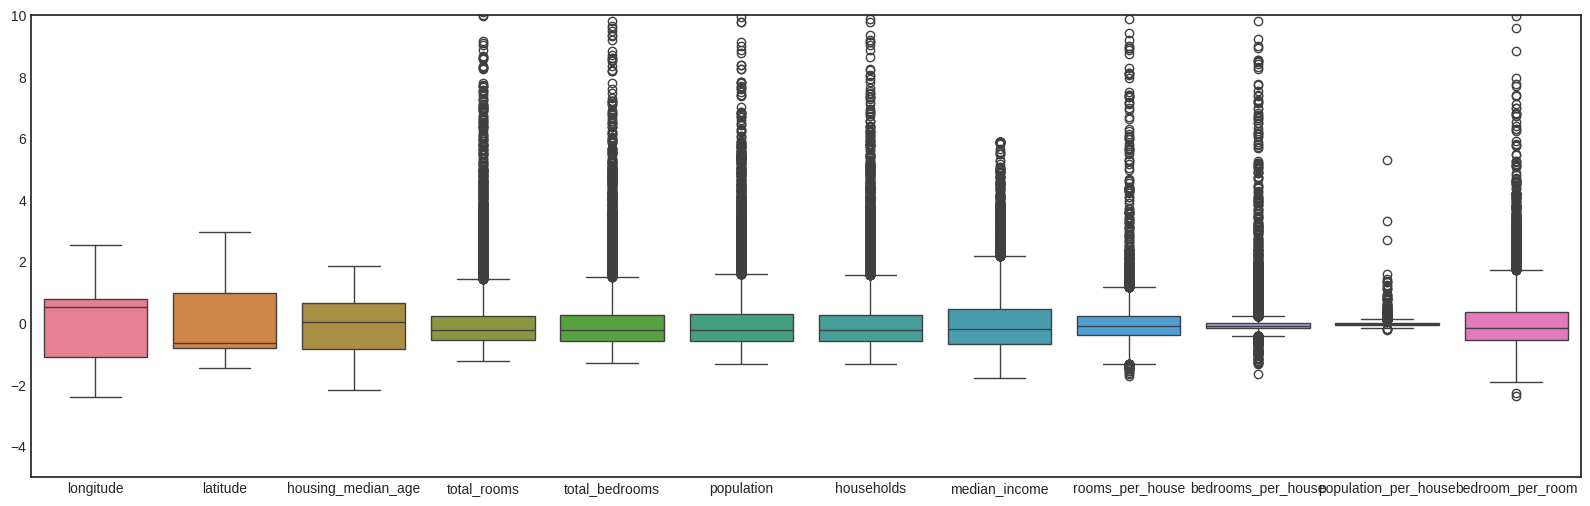

In [131]:
plt.figure(figsize=(20,6))
sns.boxplot(data=X_train_num)
plt.ylim(-5,10);

### 1.2.5. Enconding

In [136]:
X_train_cat = X_train.select_dtypes(include='object')

In [137]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
X_train_cat = ohe.fit_transform(X_train_cat)
new_cols = list(map(lambda x: inflection.parameterize(x, separator='_'), ohe.categories_[0].tolist()))
X_train_cat = X_train_cat.set_axis(new_cols, axis='columns')

,1h_ocean,inland,island,near_bay,near_ocean
16559,1.0,0.0,0.0,0.0,0.0
11233,0.0,0.0,0.0,0.0,1.0
2271,0.0,1.0,0.0,0.0,0.0
8660,1.0,0.0,0.0,0.0,0.0
6250,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
11287,0.0,1.0,0.0,0.0,0.0
11968,0.0,0.0,0.0,1.0,0.0
5391,0.0,1.0,0.0,0.0,0.0
860,0.0,1.0,0.0,0.0,0.0


In [138]:
X_train = X_train_num.join(X_train_cat)
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_per_house,population_per_house,bedroom_per_room,1h_ocean,inland,island,near_bay,near_ocean
16559,0.633466,-0.797298,0.905259,-0.093871,-0.148028,0.205467,-0.123907,-0.350246,-0.024518,-0.092986,0.047954,-0.262120,1.0,0.0,0.0,0.0,0.0
11233,0.668375,-0.867525,-0.680233,-1.208771,-1.244987,-1.257045,-1.268792,-0.689468,-1.107275,-0.109307,-0.007390,2.704361,0.0,0.0,0.0,0.0,1.0
2271,1.790436,-1.082889,-1.631529,-1.123804,-1.191713,-1.262610,-1.266130,-1.263976,1.759707,1.390615,-0.040149,-0.322729,0.0,1.0,0.0,0.0,0.0
8660,0.942656,-0.956480,-1.631529,-0.144100,-0.666238,-0.487302,-0.701675,5.815693,1.705786,0.012530,0.063309,-1.429438,1.0,0.0,0.0,0.0,0.0
6250,0.648427,-0.801980,0.588160,-0.548751,-0.465250,-0.257306,-0.467373,-1.128308,-0.352857,-0.067355,0.039793,0.303631,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11287,-0.867602,1.426562,-0.521684,-0.675966,-0.801844,-0.815602,-0.736288,-0.003486,-0.031771,-0.307239,-0.055965,-0.580246,0.0,1.0,0.0,0.0,0.0
11968,-1.296479,0.991154,1.539455,-0.414493,-0.358702,-0.453915,-0.400810,-1.280473,-0.161750,0.017807,-0.035424,0.114395,0.0,0.0,0.0,1.0,0.0
5391,-1.675486,2.737469,-0.680233,0.776455,0.607493,0.348287,0.427235,-0.602923,0.408878,0.151750,-0.031215,-0.430589,0.0,1.0,0.0,0.0,0.0
860,1.187016,-0.727071,-0.521684,-0.078380,0.040852,0.132202,-0.014744,-0.639502,-0.170722,0.028119,0.007640,0.145913,0.0,1.0,0.0,0.0,0.0


In [139]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_house', 'bedrooms_per_house', 'population_per_house',
       'bedroom_per_room', '1h_ocean', 'inland', 'island', 'near_bay',
       'near_ocean'],
      dtype='object')

## 1.3. Bivariate Analysis

### 1.3.1. Correlations

<Axes: >

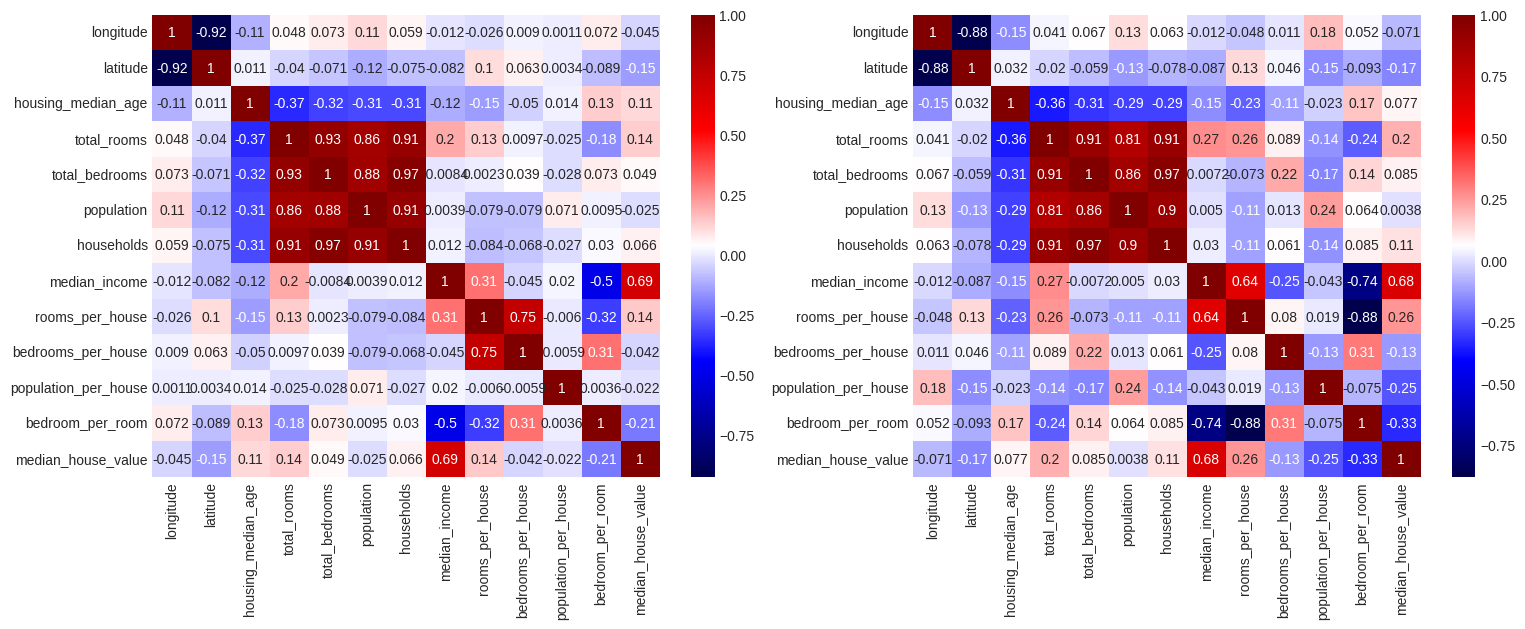

In [140]:
cols_drop = ['1h_ocean', 'inland', 'island', 'near_bay','near_ocean']

df_corr = X_train.drop(columns=cols_drop).join(y_train)

corr_matrix_pe = df_corr.corr(method='pearson')
corr_matrix_sp = df_corr.corr(method='spearman')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.heatmap(data=corr_matrix_pe, annot=True, cmap='seismic', ax=ax[0])
sns.heatmap(data=corr_matrix_sp, annot=True, cmap='seismic', ax=ax[1])

In [141]:
pd.DataFrame({'Pearson': corr_matrix_pe['median_house_value'],
              'Spearman': corr_matrix_sp['median_house_value']}).sort_values(by=['Pearson', 'Spearman'], ascending=False)

,Pearson,Spearman
median_house_value,1.000000,1.000000
median_income,0.686227,0.676131
rooms_per_house,0.142011,0.257514
total_rooms,0.135003,0.204649
housing_median_age,0.109199,0.077401
households,0.066468,0.112379
total_bedrooms,0.049360,0.084885
population_per_house,-0.022142,-0.254205
population,-0.025077,0.003768
bedrooms_per_house,-0.042442,-0.127993


**OBS:**
- median_income, rooms_per_house, total_rooms, bedroom_per_room and bedrooms_per_house seems to be the most correlated features with the target
- population_per_house should be tested

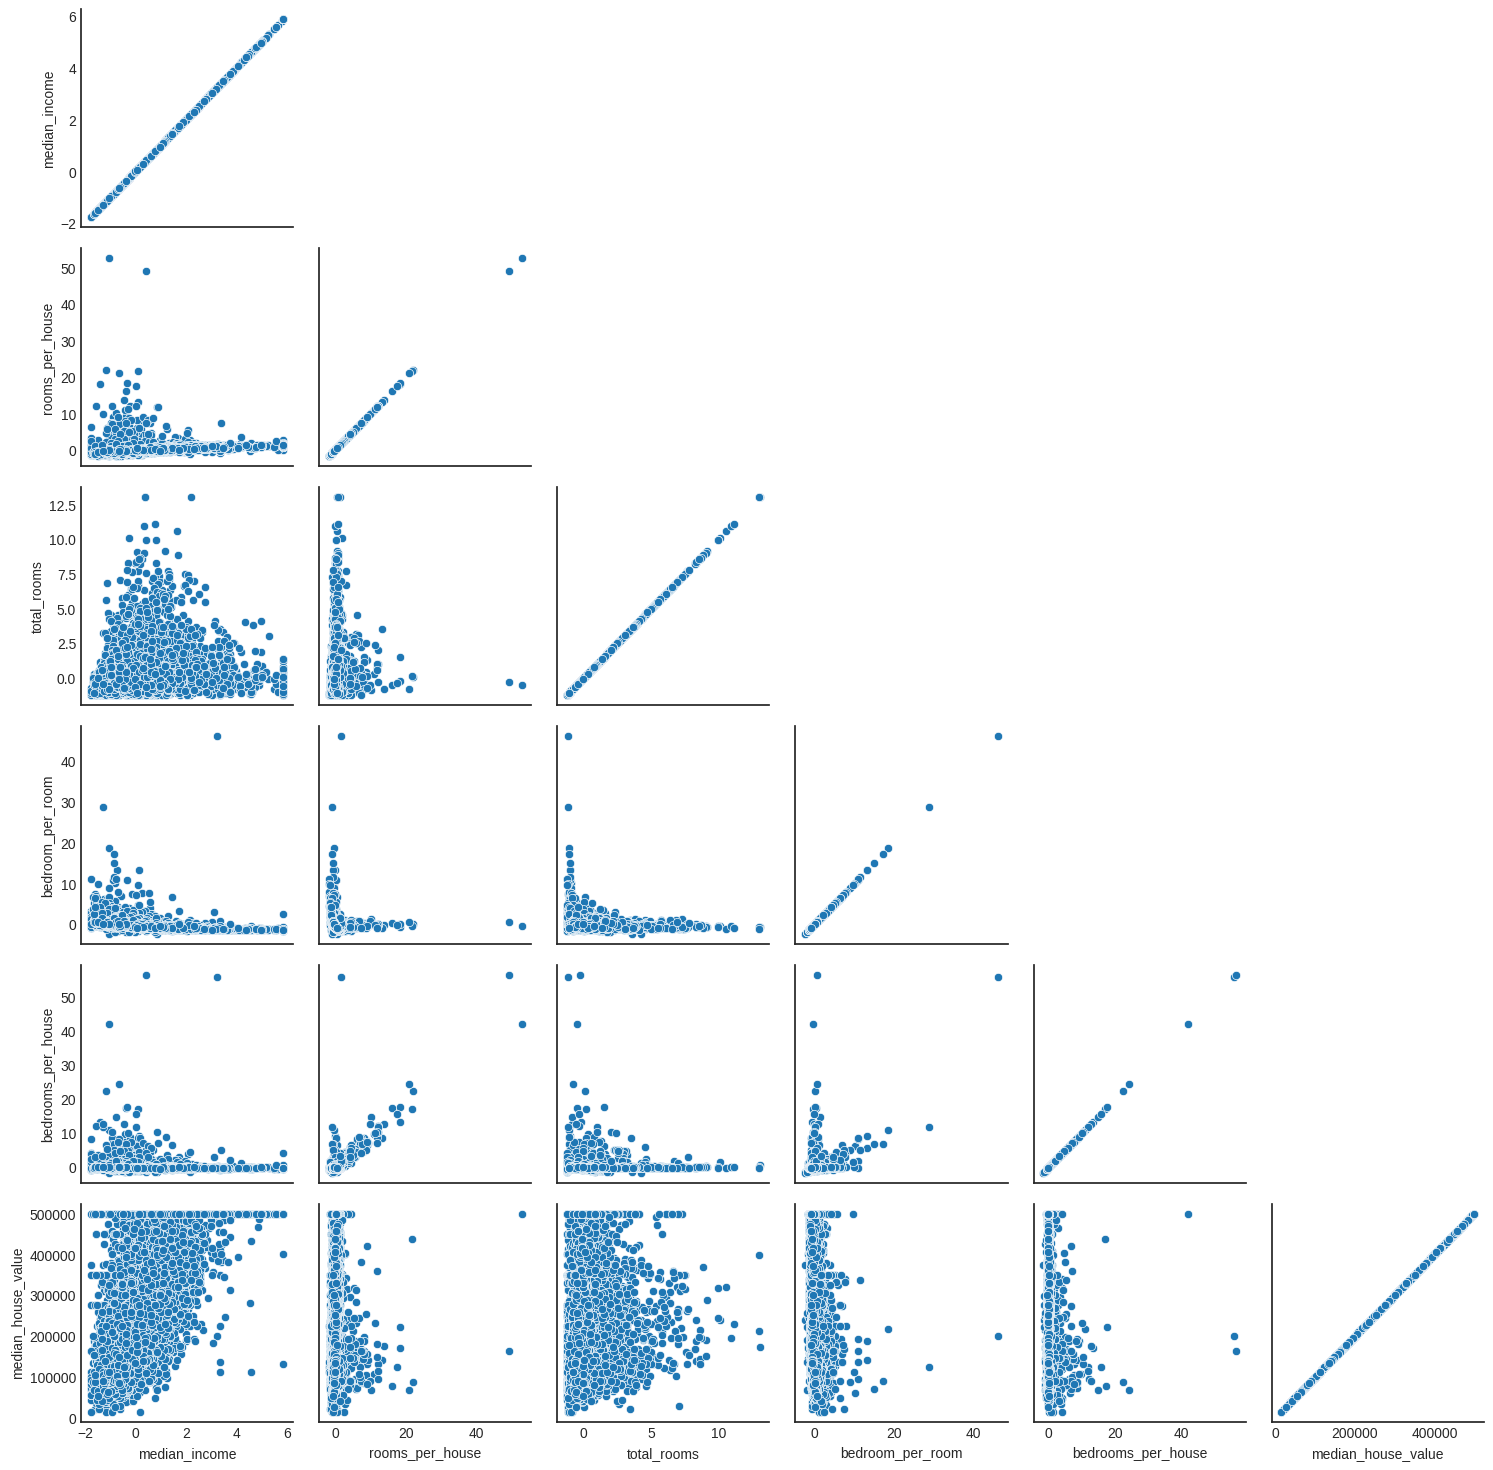

In [142]:
attributes = ['median_income', 'rooms_per_house', 'total_rooms', 'bedroom_per_room', 'bedrooms_per_house']
#attributes = ['median_income', 'rooms_per_house', 'total_rooms', 'bedroom_per_room', 'bedrooms_per_house', 'population_per_house']

aux = sns.PairGrid(data=X_train[attributes].join(y_train), corner=True)
aux.map(sns.scatterplot)

**Summary:**
- Numerical features don't present significant correlation with the target variable

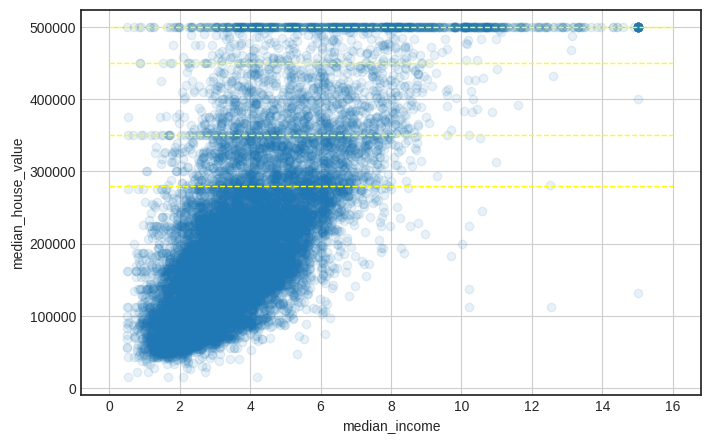

In [195]:
plt.figure(figsize=(8,5))
plt.scatter(x=X_train['median_income'], y=y_train['median_house_value'], alpha=0.1)
plt.hlines(500000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(450000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(350000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.hlines(280000, xmin=0, xmax=16, colors='yellow', linestyles='--', linewidth=1)
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.grid();

- Some well defined value levels are present
- Horizontal lines show the repeated values at US\$ 500k, US\$ 450k, US\$ 350k and, maybe, at US\$ 280k
- Such behavior could add some bias to the model
- Suppress those values for training the model is plausible

## 1.4. Multivariate analysis

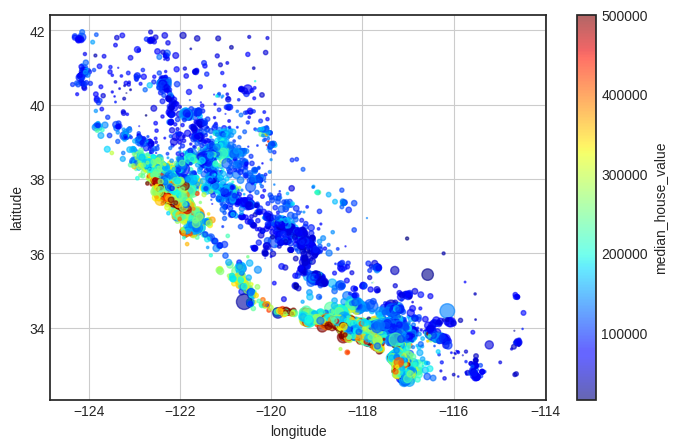

In [198]:
plt.figure(figsize=(8,5))
plt.scatter(x=df_train['longitude'], y=df_train['latitude'],
            alpha=0.6,
            s=df_train['population']/100,
            c=df_train['median_house_value'],
            cmap=plt.get_cmap('jet'))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label='median_house_value')
plt.grid()

**OBS:**
- The most expensive houses are near ocean, as well as the most populous ones